## PAW wavelet decomposition

In [4]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [6]:
""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pandas as pd
from one.api import ONE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy import stats
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')
# # Get my functions
# functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses//'
# os.chdir(functions_path)
# from clustering_functions import GMM_neg_log_likelihood

# Get my functions
from functions import idxs_from_files, fast_wavelet_morlet_convolution_parallel, plot_kde, get_speed, GMM_neg_log_likelihood

one = ONE(mode='remote')

In [7]:
""" 
LOAD DATA AND PARAMETERS
"""
# LOAD DATA

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

# Wavelet decomposition
f = np.array([.25, .5, 1, 2, 4, 8, 16])
omega0 = 5

In [8]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))

# Paw positions

In [ ]:
concatenated_subsampled = np.array([])

paws = ['l_paw',  'r_paw']
var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    for v, var in enumerate(paws):
        for c, coor in enumerate(['_x', '_y']):
            
            design_matrix[var+coor] = stats.zscore(np.array(design_matrix[var+coor]), 
                                                   nan_policy='omit', axis=0)  #stats.zscore(data_df[paw_vars], axis=0)
            array = np.array(design_matrix[var+coor]) 
            not_nan = ~np.isnan(array)
            clean_array = array[not_nan]# np.array(stats.zscore(design_matrix[var][not_nan_x]))
            
            # Wavelet decomposition of paw position
            dt = np.round(np.mean(np.diff(design_matrix['Bin'])), 3)
            amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(clean_array, f, omega0, dt)

            # Wavelet transforms
            for i, frequency in enumerate(f):
                # Create new column with frequency
                design_matrix[str(var+coor+str(frequency))] = design_matrix['Bin'] * np.nan
                design_matrix[str(var+coor+str(frequency))] = np.nan
                design_matrix[str(var+coor+str(frequency))][not_nan] = amp[i, :]

    # Prepare data
    data_df = design_matrix[var_interest].copy().dropna()
    data = np.array(data_df)
    
    """ Randomly subsample """
    n_samples = 20000
    sampled_indices = np.random.choice(data.shape[0], 
                                       n_samples, 
                                       replace=False)
    sampled_data = data[sampled_indices, :]
    
    """ Perform t-SNE """
    X = sampled_data.copy()
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=32).fit_transform(X)
    # plt.scatter(X_embedded[:, ], X_embedded[:, 1], alpha=0.02)
    # plt.show()
    
    """ Perform Gaussian kde """
    values = X_embedded.T.copy()
    kernel = stats.gaussian_kde(values)
    # plot_kde(X_embedded, kernel)
    
    """ Resample weighted by kde estimate """
    sample_prob = kernel(values)
    norm_sample_prob = sample_prob/ np.sum(sample_prob)
    resampled_indices = np.random.choice(sampled_data.shape[0], 
                                    size=2000, 
                                    p=norm_sample_prob, replace=False)
    resampled_data = sampled_data[resampled_indices, :]
    
    """ Concatenate session """
    if len(concatenated_subsampled) == 0:
        concatenated_subsampled = resampled_data.copy()
    else:
        concatenated_subsampled = np.vstack([concatenated_subsampled, resampled_data])
    
    print(mat)

/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0027', '0f77ca5d-73c2-45bd-aa4c-4c5ed275dbde')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-47', '288bfbf3-3700-4abe-b6e4-130b5c541e61')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA006', '19e66dc9-bf9f-430b-9d6a-acfa85de6fb7')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('CSH_ZAD_026', '5d01d14e-aced-4465-8f8e-9a1c674f62ec')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL016', '58c4bf97-ec3b-45b4-9db4-d5d9515d5b00')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-65', '8c025071-c4f3-426c-9aed-f149e8f75b7b')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA036', 'e2b845a1-e313-4a08-bc61-a5f662ed295e')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0020', 'eacc49a9-f3a1-49f1-b87f-0972f90ee837')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA052', '687017d4-c9fc-458f-a7d5-0979fe1a7470')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA033', '32d27583-56aa-4510-bc03-669036edad20')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA017', 'bb099402-fb31-4cfd-824e-1c97530a0875')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA048', 'dc962048-89bb-4e6a-96a9-b062a2be1426')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-45', '537677fe-1e24-4755-948c-fa4a4e8ecce5')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-01937', '0b7ee1b6-42db-46cd-a465-08f531366187')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL030', 'c16d3557-b2c1-4545-93d0-112ac0915d93')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_052', 'fc14c0d6-51cf-48ba-b326-56ed5a9420c3')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL033', '37ac03f1-9831-4a30-90fc-a59e635b98bd')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_016', 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA034', '8a3a0197-b40a-449f-be55-c00b23253bbf')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-21', 'ebe2efe3-e8a1-451a-8947-76ef42427cc9')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_061', '493170a6-fd94-4ee4-884f-cc018c17eeb9')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_20', '037d75ca-c90a-43f2-aca6-e86611916779')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-48', 'a405053a-eb13-4aa4-850c-5a337e5dc7fd')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0017', 'e6043c7d-8f6e-4b66-8309-2ec0abac0f79')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-48', '3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA049', '8a1cf4ef-06e3-4c72-9bc7-e1baa189841b')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_29', 'af55d16f-0e31-4073-bdb5-26da54914aa2')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA049', '0841d188-8ef2-4f20-9828-76a94d5343a4')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL034', '6cbeead9-bb7a-40e1-8ccd-47ae60239654')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_052', '1928bf72-2002-46a6-8930-728420402e01')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-39', '35ed605c-1a1a-47b1-86ff-2b56144f55af')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_054', '6c6983ef-7383-4989-9183-32b1a300d17a')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_020', '9fe512b8-92a8-4642-83b6-01158ab66c3c')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_29', 'd2832a38-27f6-452d-91d6-af72d794136c')


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when

('NYU-48', '93ad879a-aa42-4150-83e1-38773c9785e4')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-01936', '9b5a1754-ac99-4d53-97d3-35c2f6638507')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL031', 'ef38e503-dd79-4185-bf87-4712d4f274fe')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('CSH_ZAD_029', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-02368', 'a4a74102-2af5-45dc-9e41-ef7f5aed88be')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-46', '72982282-e493-45ee-87ce-aa45cb3a3ec1')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-02372', '88224abb-5746-431f-9c17-17d7ef806e6a')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_060', '81a1dca0-cc90-47c5-afe3-c277319c47c8')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_27', '952870e5-f2a7-4518-9e6d-71585460f6fe')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-02372', '7cec9792-b8f9-4878-be7e-f08103dc0323')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_29', '0cc486c3-8c7b-494d-aa04-b70e2690bcba')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL015', '9a6e127b-bb07-4be2-92e2-53dd858c2762')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-65', 'a2ec6341-c55f-48a0-a23b-0ef2f5b1d71e')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_039', '768a371d-7e88-47f8-bf21-4a6a6570dd6e')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_18', 'cae5cd75-55e5-4277-8db3-cf4d6c5ff918')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL024', '30af8629-7b96-45b7-8778-374720ddbc5e')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('CSH_ZAD_019', '7f6b86f9-879a-4ea2-8531-294a221af5d0')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA005', 'd57df551-6dcb-4242-9c72-b806cff5613a')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL030', '283ecb4c-e529-409c-9f0a-8ea5191dcf50')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-46', '6434f2f5-6bce-42b8-8563-d93d493613a2')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-01936', '3f6e25ae-c007-4dc3-aa77-450fd5705046')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA011', '824cf03d-4012-4ab1-b499-c83a92c5589e')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-45', '5bcafa14-71cb-42fa-8265-ce5cda1b89e0')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-46', '64e3fb86-928c-4079-865c-b364205b502e')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_065', '1425bd6f-c625-4f6a-b237-dc5bcfc42c87')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0027', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_043', 'f3ce3197-d534-4618-bf81-b687555d1883')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_29', '58b1e920-cfc8-467e-b28b-7654a55d0977')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_061', '360eac0c-7d2d-4cc1-9dcf-79fc7afc56e7')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_043', '695a6073-eae0-49e0-bb0f-e9e57a9275b9')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_29', '86b6ba67-c1db-4333-add0-f8105ea6e363')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL017', '1b61b7f2-a599-4e40-abd6-3e758d2c9e25')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_052', '22e04698-b974-4805-b241-3b547dbf37bf')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL031', 'c23b4118-db40-4333-af1d-933154b533c6')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_016', '5339812f-8b91-40ba-9d8f-a559563cc46b')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA035', '6f36868f-5cc1-450c-82fa-6b9829ce0cfe')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-40', '5157810e-0fff-4bcf-b19d-32d4e39c7dfc')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA044', '23c75e0b-05d8-452e-8efb-a3687ab94079')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_016', 'c3d9b6fb-7fa9-4413-a364-92a54df0fc5d')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0027', '195443eb-08e9-4a18-a7e1-d105b2ce1429')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-01937', '113c5b6c-940e-4b21-b462-789b4c2be0e5')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA034', 'ebc9392c-1ecb-4b4b-a545-4e3d70d23611')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-02373', '0802ced5-33a3-405e-8336-b65ebc5cb07c')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL017', '10fac7a1-919d-4ca7-83c4-4675bd8d9416')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_053', '75b6b132-d998-4fba-8482-961418ac957d')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_020', '948fd27b-507b-41b3-bdf8-f9f5f0af8e0b')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_018', 'e8b4fda3-7fe4-4706-8ec2-91036cfee6bd')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('CSH_ZAD_026', 'e56541a5-a6d5-4750-b1fe-f6b5257bfe7c')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0020', '3e6a97d3-3991-49e2-b346-6948cb4580fb')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-47', 'fc43390d-457e-463a-9fd4-b94a0a8b48f5')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('PL017', 'f27e6cd6-cdd3-4524-b8e3-8146046e2a7d')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NYU-40', '71855308-7e54-41d7-a7a4-b042e78e3b4f')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_058', 'd3a2b25e-46d3-4f0b-ade6-4e32255f4c35')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_020', '4a45c8ba-db6f-4f11-9403-56e06a33dfa4')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0019', 'b887df2c-bb9c-44c9-a9c0-538da87b2cab')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_26', '09394481-8dd2-4d5c-9327-f2753ede92d7')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-02370', '6f6d2c8e-28be-49f4-ae4d-06be2d3148c1')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_27', '73918ae1-e4fd-4c18-b132-00cb555b1ad2')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_060', '875c1e5c-f7ec-45ac-ab82-ecfe7276a707')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_018', 'cde63527-7f5a-4cc3-8ac2-215d82e7da26')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_043', 'c6db3304-c906-400c-aa0f-45dd3945b2ea')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('NR_0019', '63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_066', 'f4ffb731-8349-4fe4-806e-0232a84e52dd')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_052', 'f84045b0-ce09-4ace-9d11-5ea491620707')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA037', 'fa8ad50d-76f2-45fa-a52f-08fe3d942345')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-02370', 'd0c91c3c-8cbb-4929-8657-31f18bffc294')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ZFM-04308', '239dd3c9-35f3-4462-95ee-91b822a22e6b')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_052', '7416f387-b302-4ca3-8daf-03b585a1b7ec')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('UCLA037', 'bda2faf5-9563-4940-a80f-ce444259e47b')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_29', '72028382-a869-4745-bacf-cb8789e16953')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_018', '54238fd6-d2d0-4408-b1a9-d19d24fd29ce')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('DY_020', 'e012d3e3-fdbc-4661-9ffa-5fa284e4e706')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('CSH_ZAD_026', '626126d5-eecf-4e9b-900e-ec29a17ece07')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('SWC_043', '6f09ba7e-e3ce-44b0-932b-c003fb44fb89')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

('ibl_witten_26', 'a9138924-4395-4981-83d1-530f6ff7c8fc')


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_28395/1109416929.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the docum

In [92]:
np.save(open('supersession_wavelets_paw09-09-2025', 'wb'), concatenated_subsampled)

/tmp/ipykernel_31717/786210614.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


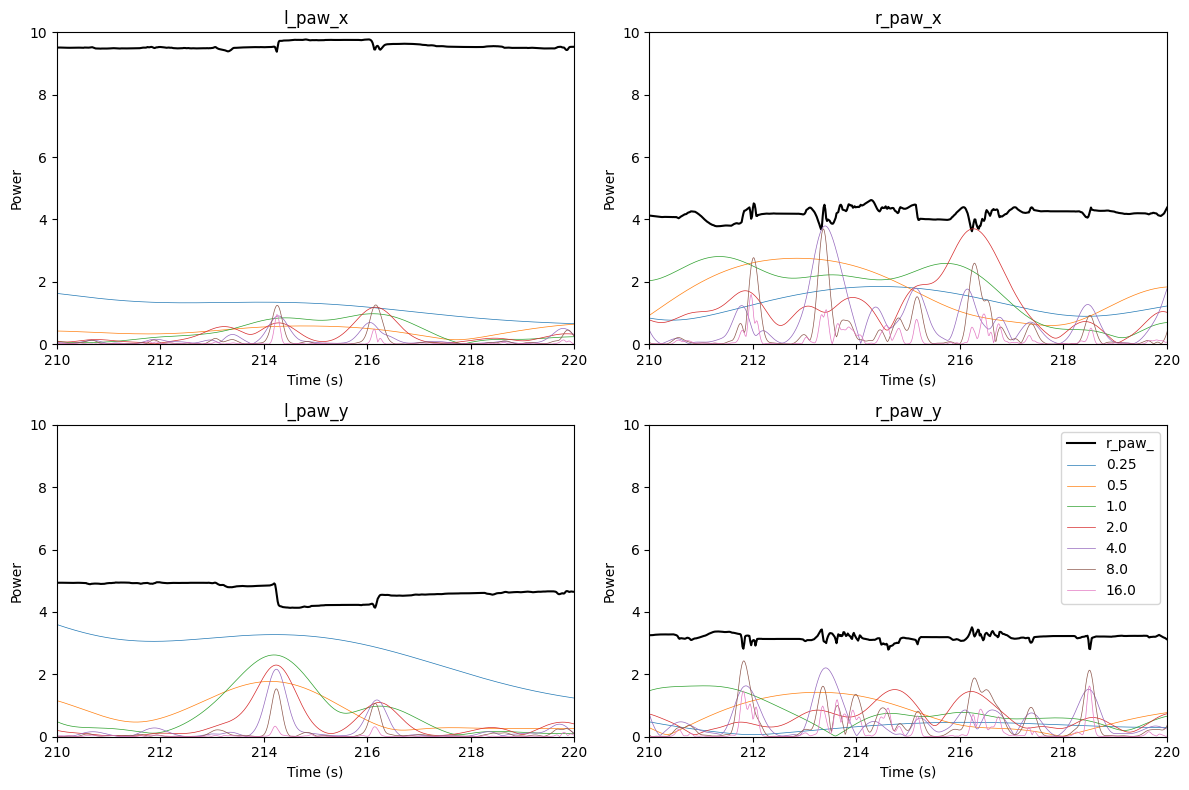

In [107]:
init = 210
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
for v, var in enumerate(['l_paw_', 'r_paw_']):
    for c, coor in enumerate(['x', 'y']):
        ax[c, v].plot(design_matrix['Bin'], design_matrix[var+coor]/100, label=var, color='k')
        # ax[c, v].plot(design_matrix['Bin'], np.abs(design_matrix['avg_wheel_vel'])+4, label='wheel vel', color='grey')
        # ax[c, v].plot(design_matrix['Bin'], design_matrix['avg_wheel_vel']+4, label='wheel vel', color='grey')
        # ax[c, v].plot(design_matrix['Bin'], np.abs(design_matrix[var+coor+'_vel'])+4, label='paw vel', color='grey')

        # Wavelet transforms
        for i, frequency in enumerate(f):
            ax[c, v].plot(design_matrix['Bin'], design_matrix[var+coor+str(frequency)], label=str(frequency), linewidth=.5)
            ax[c, v].set_xlim([init, init+10])
            ax[c, v].set_ylim([0, 10])
            ax[c, v].set_ylabel('Power')
            ax[c, v].set_xlabel('Time (s)')
        ax[c, v].set_title(var+coor)
    ax[1, 1].legend()
    plt.tight_layout()

## With paw velocity

In [43]:
concatenated_subsampled = np.array([])

paws = ['l_paw',  'r_paw']

var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

for m, mat in enumerate(sessions_to_process[:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    
    left_speeds = get_speed(design_matrix, design_matrix['Bin'], 'left', split=True, feature='l_paw')
    right_speeds = get_speed(design_matrix, design_matrix['Bin'], 'right', split=True, feature='r_paw')
    for v, var in enumerate(paws):
        for c, coor in enumerate(['_x', '_y']):
            array = np.array(left_speeds[c+1]) if var=='left' else np.array(right_speeds[c+1])
            not_nan = ~np.isnan(array)
            clean_array = array[not_nan]# np.array(stats.zscore(design_matrix[var][not_nan_x]))
            # Wavelet decomposition of wheel velocity
            dt = np.round(np.mean(np.diff(design_matrix['Bin'])), 3)
            amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(clean_array, f, omega0, dt)

            # Wavelet transforms
            for i, frequency in enumerate(f):
                # Create new column with frequency
                design_matrix[str(var+coor+str(frequency))] = design_matrix['Bin'] * np.nan
                design_matrix[str(var+coor+str(frequency))] = np.nan
                design_matrix[str(var+coor+str(frequency))][not_nan] = amp[i, :]

            
    # plt.bar(x=design_matrix.mean().keys()[15:], height = design_matrix.mean()[15:])
    # plt.show()
    

    # Prepare data
    data_df = design_matrix[var_interest].copy().dropna()
    data_df[paw_vars] = stats.zscore(np.array(data_df[paw_vars]), axis=0)  #stats.zscore(data_df[paw_vars], axis=0)
    
    # data = np.array(design_matrix[var_interest].copy().dropna())
    data = np.array(data_df)
    
    """ Randomly subsample """
    n_samples = 20000
    sampled_indices = np.random.choice(data.shape[0], 
                                       n_samples, 
                                       replace=False)
    sampled_data = data[sampled_indices, :]
    
    """ Perform t-SNE """
    X = sampled_data.copy()
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=32).fit_transform(X)
    # plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.02)
    # plt.show()
    
    """ Perform Gaussian kde """
    values = X_embedded.T.copy()
    kernel = stats.gaussian_kde(values)
    # plot_kde(X_embedded, kernel)
    
    """ Resample weighted by kde estimate """
    sample_prob = kernel(values)
    norm_sample_prob = sample_prob/ np.sum(sample_prob)
    resampled_indices = np.random.choice(sampled_data.shape[0], 
                                    size=2000, 
                                    p=norm_sample_prob, replace=False)
    resampled_data = sampled_data[resampled_indices, :]
    
    """ Concatenate session """
    if len(concatenated_subsampled) == 0:
        concatenated_subsampled = resampled_data.copy()
    else:
        concatenated_subsampled = np.vstack([concatenated_subsampled, resampled_data])
    
    print(mat)

/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:397: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_31717/3346061468.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

KeyboardInterrupt: 

# Wavelet clustering

In [224]:
data = concatenated_subsampled[:, :4].copy()
# data = np.array(data.drop(columns=['Bin', 'avg_wheel_vel', 'l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']).dropna()) 
X_centered = data - np.mean(data, axis=0)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (20,) and arg 1 with shape (0,).

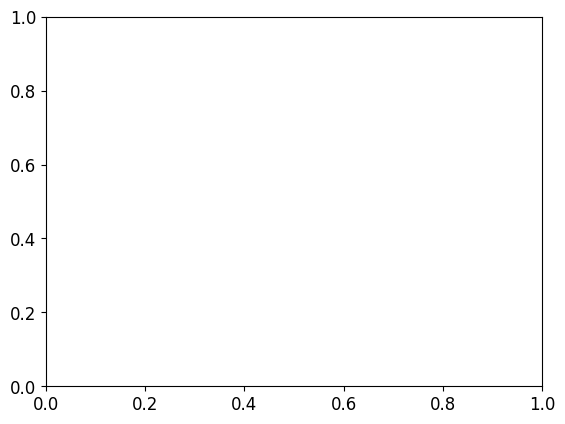

In [225]:
plt.bar(np.arange(0, 20, 1), np.nanmean(data, axis=0)[4:])
# plt.xlim([100, 200])

In [227]:
from sklearn.decomposition import PCA

n_components = 4
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(stats.zscore(data, axis=1))
# pca = PCA(n_components)  # Reduce to 50 dimensions
# X_pca = pca.fit_transform(data)

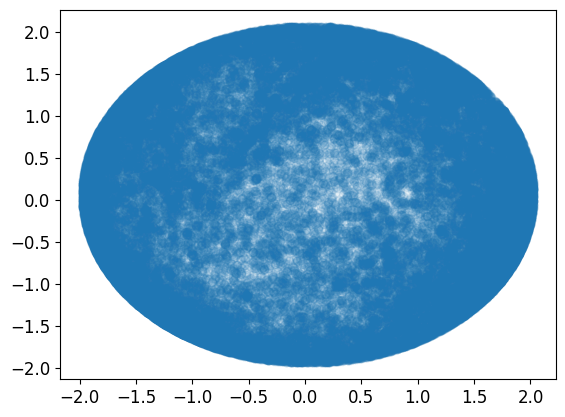

In [228]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.1)

(0.0, 1.0)

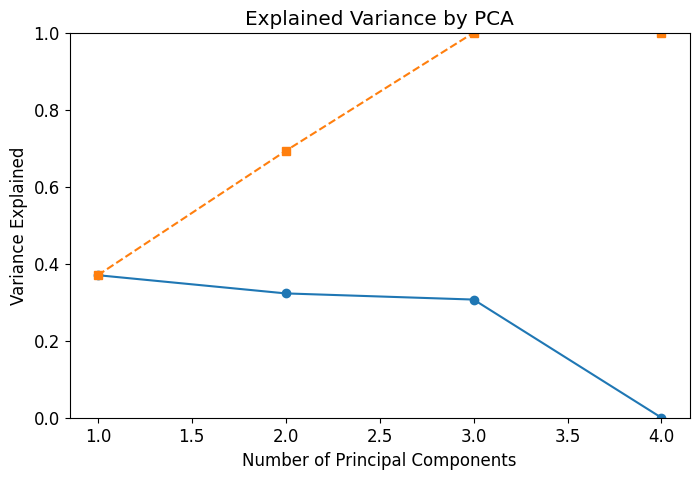

In [229]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")
plt.ylim([0, 1])

## t-SNE

In [120]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=32).fit_transform(data)

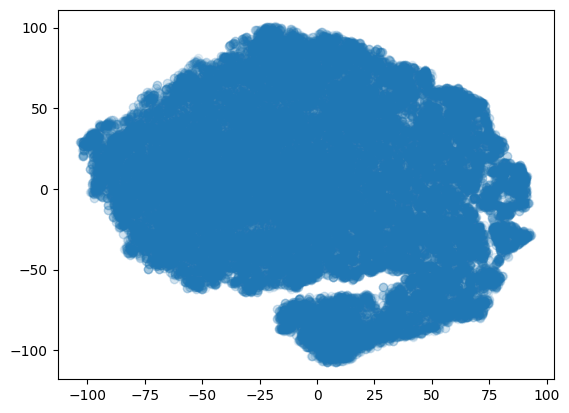

In [121]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=.1)

In [64]:
from sklearn import mixture

def GMM_neg_log_likelihood(embedding, components):
    
    LL = np.zeros(len(components)) * np.nan
    
    for i, k in enumerate(components):
        # g = mixture.GaussianMixture(n_components=k)
        # generate random sample, two components
        np.random.seed(0)

        # concatenate the two datasets into the final training set
        cutoff = int(np.shape(embedding)[0]*0.8)
        train_indices = np.random.choice(embedding.shape[0], cutoff, replace=False)
        X_train = np.vstack([embedding[train_indices, 0], embedding[train_indices, 1]]).T

        # fit a Gaussian Mixture Model with two components
        clf = mixture.GaussianMixture(n_components=k, covariance_type='full')
        clf.fit(X_train)

        all_indices = np.arange(0, embedding.shape[0], 1)
        test_indices = [idx for idx in all_indices if idx not in train_indices]
        X_test = np.vstack([embedding[test_indices, 0], embedding[test_indices, 1]])
        LL[i] = -clf.score(X_test.T)
        
    return LL

In [230]:
use_data = X_pca[:, :10].copy()
# use_data = X_embedded.copy()
use_data = data.copy()

repeats = 1
components = np.array([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
# components = np.array([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 40, 60, 100, 500, 1000])
components = np.arange(1, 31, 1)
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(use_data.copy(), components)
kneedle = KneeLocator(components[1:], np.nanmean(LLs, axis=0)[1:], curve="convex", direction="decreasing")
kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee

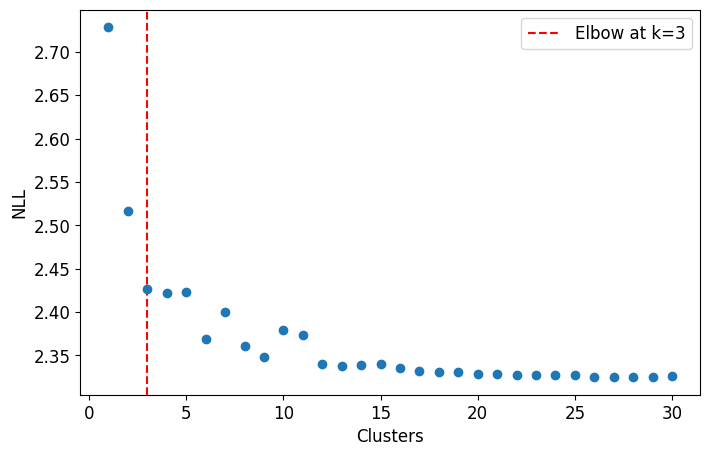

In [231]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components, np.nanmean(LLs, axis=0), np.nanstd(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

# kMeans on supersession

In [248]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans.fit(concatenated_subsampled[:, :4].copy())
centroids = kmeans.cluster_centers_

In [249]:
paws = ['l_paw',  'r_paw']
var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']
var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']
for m, mat in enumerate(sessions_to_process[:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    for v, var in enumerate(paws):
        for c, coor in enumerate(['_x', '_y']):
            
            design_matrix[var+coor] = stats.zscore(np.array(design_matrix[var+coor]), 
                                                   nan_policy='omit', axis=0)  #stats.zscore(data_df[paw_vars], axis=0)
            array = np.array(design_matrix[var+coor]) 
            not_nan = ~np.isnan(array)
            clean_array = array[not_nan]# np.array(stats.zscore(design_matrix[var][not_nan_x]))
            
            # Wavelet decomposition of paw position
            dt = np.round(np.mean(np.diff(design_matrix['Bin'])), 3)
            amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(clean_array, f, omega0, dt)

            # Wavelet transforms
            for i, frequency in enumerate(f):
                # Create new column with frequency
                # design_matrix[str(var+coor+str(frequency))] = design_matrix['Bin'] * np.nan
                design_matrix[str(var+coor+str(frequency))] = np.nan
                design_matrix[str(var+coor+str(frequency))][not_nan] = amp[i, :]

    # Prepare data
    # data_df = design_matrix[var_interest].copy().dropna()
    # # data_df[paws] = stats.zscore(np.array(data_df[paws]), axis=0)  #stats.zscore(data_df[paw_vars], axis=0)
    
    # zscored_data = design_matrix[var_interest].copy()
    # zscored_data[paw_vars] = stats.zscore(np.array(zscored_data[paw_vars]), axis=0, nan_policy='omit') 
    var_array = np.array(design_matrix[var_interest].copy())
    not_nan = ~np.isnan(var_array).any(axis=1)
    data = var_array[not_nan, :]
        
    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)
    
    design_matrix['paw_states'] = np.nan
    design_matrix['paw_states'][not_nan] = states

/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_38313/1641613851.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [250]:
use_data = design_matrix.copy()
wavelet_vars = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

paw_vars = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']
paw_df = pd.melt(use_data, id_vars=['paw_states'], value_vars=paw_vars)

wavelet_df = pd.melt(use_data, id_vars=['paw_states'], value_vars=wavelet_vars)

<Axes: xlabel='paw_states', ylabel='value'>

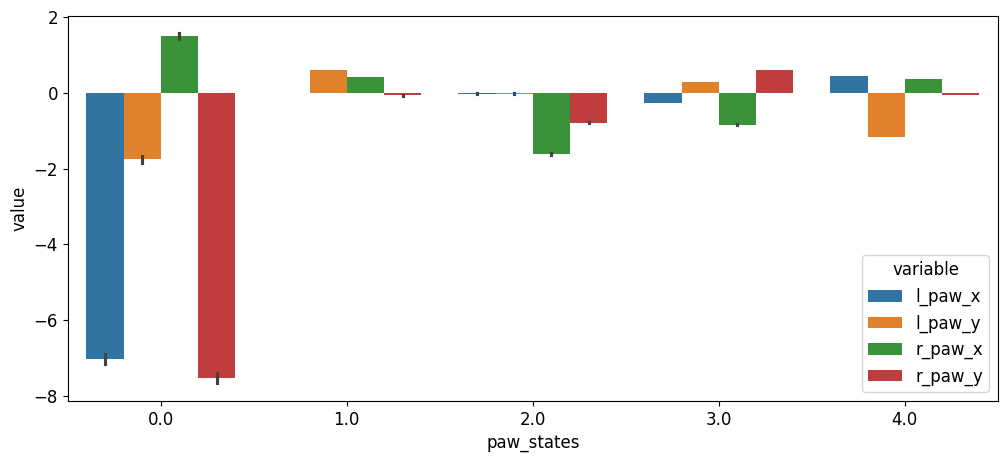

In [251]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=paw_df)

<Axes: xlabel='paw_states', ylabel='value'>

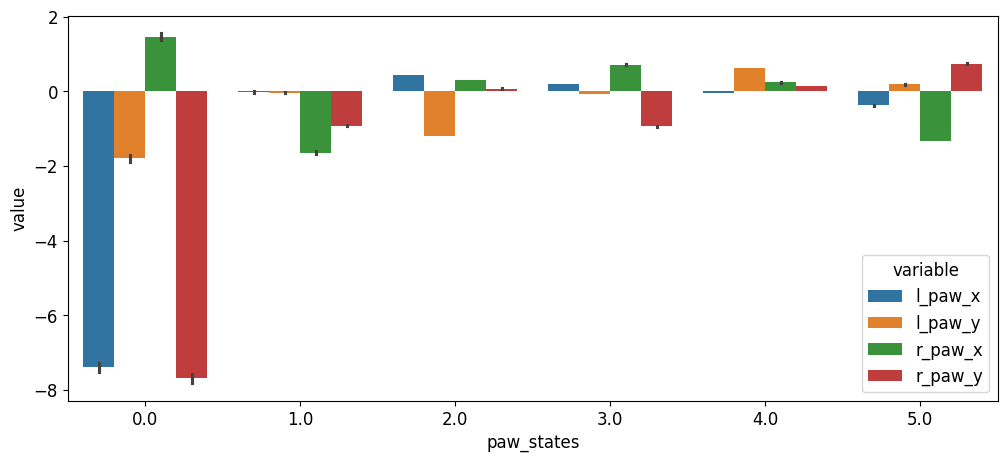

In [214]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=paw_df)

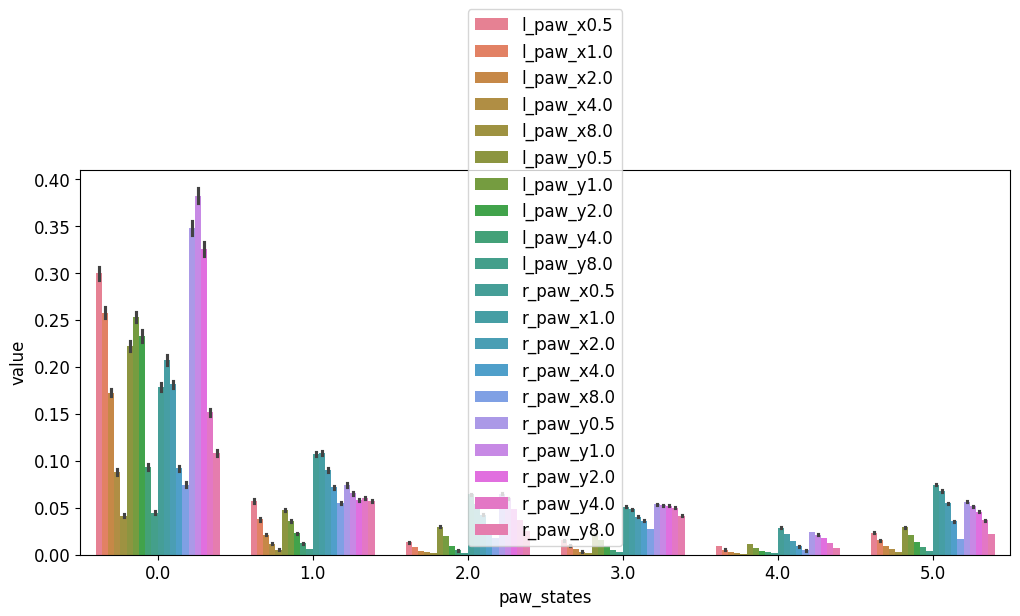

In [215]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=wavelet_df)
plt.legend()

In [216]:
palette = sns.color_palette('Set1', n_colors=optimal_k, as_cmap=True)

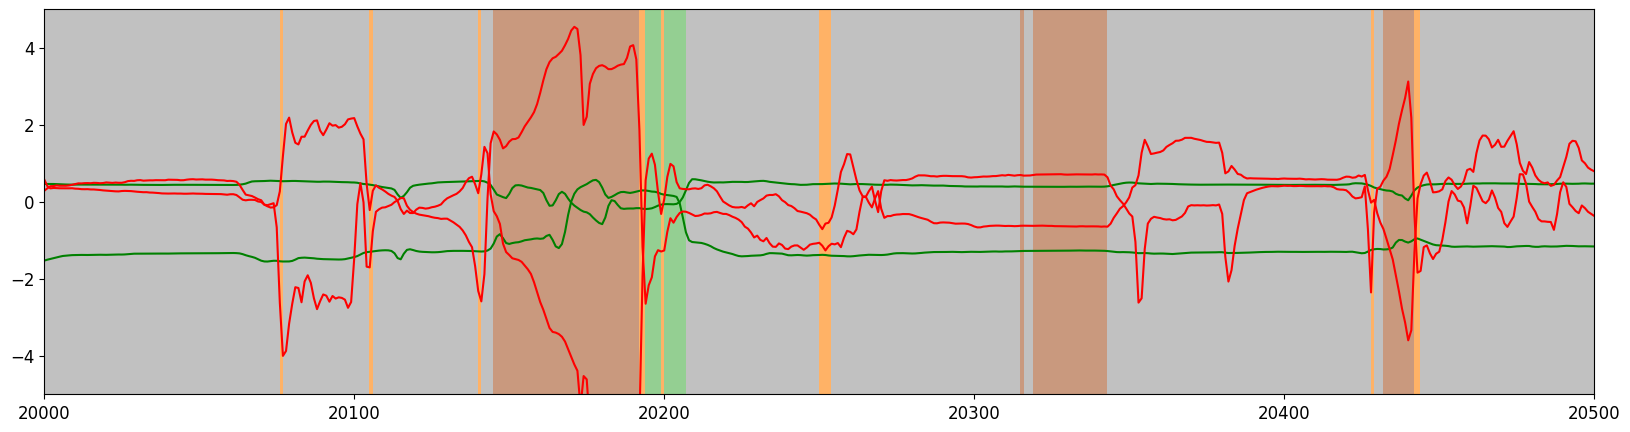

In [252]:

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
plt.rc('font', size=12)
init = 1000
# ax.plot(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), color='red')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), color='red')
attach_array = np.arange(0, optimal_k, 1)
ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])[None,:],
            extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])), -10, 10),
            aspect="auto",
            alpha=0.6,
            cmap=palette)  # 
init=20000
plt.xlim([init, init+500])
plt.ylim([-5, 5])
plt.show()

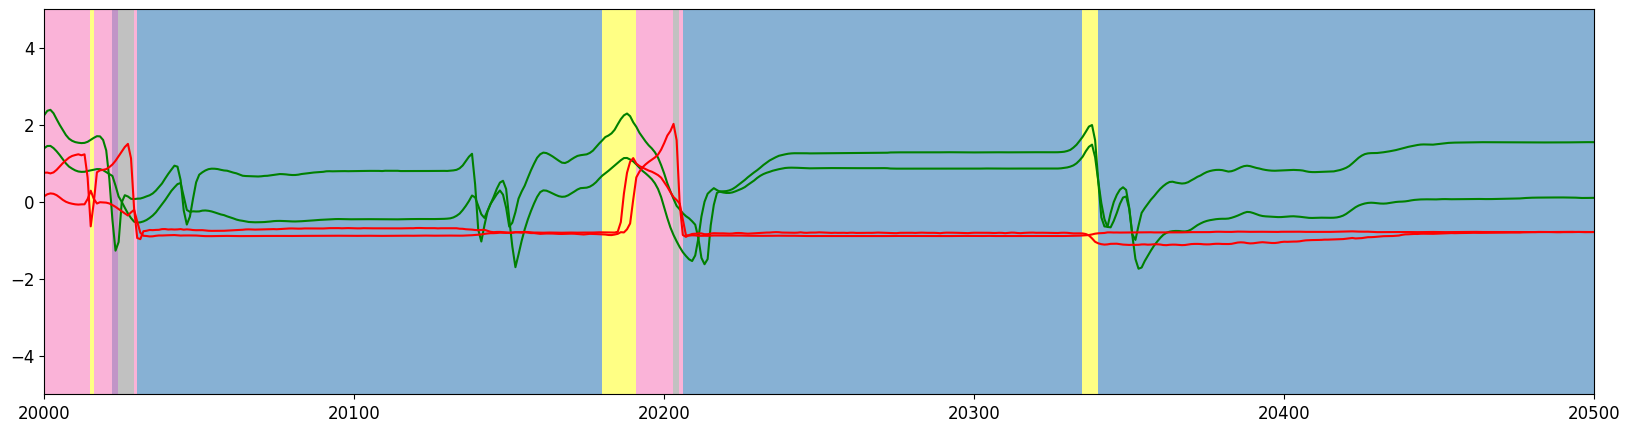

In [204]:

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
plt.rc('font', size=12)
init = 000
# ax.plot(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), color='red')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), color='red')
attach_array = np.arange(0, optimal_k, 1)
ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])[None,:],
            extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])), -10, 10),
            aspect="auto",
            alpha=0.6,
            cmap=palette)  # 
init=20000
plt.xlim([init, init+500])
plt.ylim([-5, 5])
plt.show()

In [208]:
np.unique(states)

array([0, 1, 2, 3, 4, 5])

(array([  5764.,      0., 135757.,      0.,  12257.,      0.,  19121.,
             0., 117073.,  16439.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

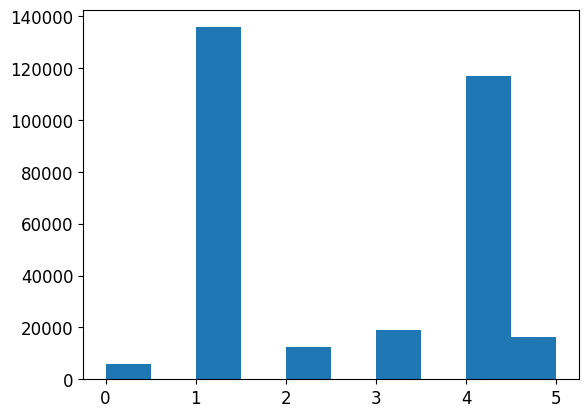

In [209]:
plt.hist(states)

(array([  1901.,   1646.,      0.,  54437.,      0.,  43663., 128132.,
             0.,  42212.,   9849.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

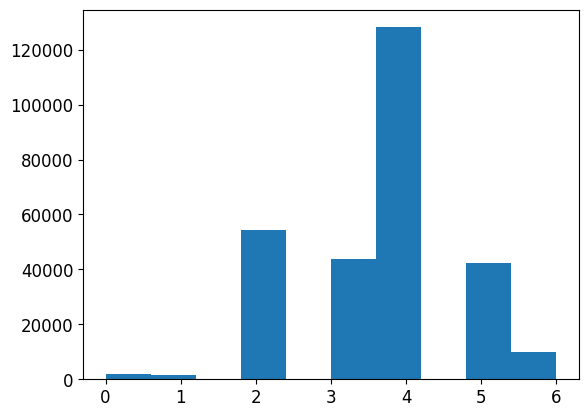

In [162]:
plt.hist(states)